In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import scipy.stats as scstats
import numpy as np

import sys
sys.path.append("../../neuroprob/")

import neuroprob as mdl
from neuroprob import utils
from neuroprob import GP

import pickle

dev = utils.pytorch.get_device(gpu=0)

import models
import CA

plt.style.use(['paper.mplstyle'])

PyTorch version: 1.7.1+cu101
Using device: cuda:0


### Utils

In [2]:
def get_full_model(datatype, cvdata, resamples, rc_t, binsize, 
                   m, rcov, max_count, units_used):
    
    mtype, ll_mode, r_mode, spk_cpl, num_induc, inv_link, C, z_dims, delays, folds, cv_switch, basis_mode = m
    shared_W = False
    enc_layers, basis = models.hyper_params(basis_mode)
    kcv, ftrain, fcov, vtrain, vcov, batch_size = cvdata

    if ll_mode == 'U':
        mapping_net = models.net(C, basis, max_count, units_used, shared_W)
    else:
        mapping_net = None

    full_model, _ = models.set_model('CA', max_count, mtype, r_mode, ll_mode, spk_cpl, fcov, units_used, 
                                     tbin, ftrain, num_induc, batch_size=batch_size, inv_link=inv_link, 
                                     mapping_net=mapping_net, C=C, enc_layers=enc_layers)
    full_model.to(dev)


    name = 'CA{}'.format(binsize)
    if shared_W:
        name += 'S'
    if basis_mode != 'ew':
        name += basis_mode
    
    model_name = '{}{}_{}_{}_{}_C={}_{}'.format(name, datatype, mtype, ll_mode, r_mode, C, kcv)
    checkpoint = torch.load('./checkpoint/' + model_name, map_location='cuda:0')
    full_model.load_state_dict(checkpoint['full_model'])
    return full_model


### Regression

In [3]:
datatype = 1 # 1D
rcov, neurons, tbin, resamples, rc_t = CA.get_dataset(datatype, 10)
max_count = int(rc_t.max())
x_counts = torch.arange(max_count+1)

# x_t, y_t, s_t, th_t, hd_t, time_t
left_x = rcov[0].min()
right_x = rcov[0].max()
bottom_y = rcov[1].min()
top_y = rcov[1].max()

In [ ]:
modes = [('GP', 'U', 'th_hd_pos_s_t', None, 64, 'identity', 3, [], False, 20, False, 'ew'), 
         ('GP', 'U', 'th_pos', None, 40, 'identity', 2, [], False, 20, False, 'qd')]

show_neuron = np.arange(neurons)

In [29]:
kcv = 5
mode = modes[0]
cvdata = models.get_cv_sets(mode, [kcv], 5000, rc_t, resamples, rcov)[0]


full_model = get_full_model(datatype, cvdata, resamples, rc_t, 10, 
                            mode, rcov, max_count, neurons)

In [55]:
### pos ###
grid_size_pos = (51, 41)
grid_shape_pos = [[left_x, right_x], [bottom_y, top_y]]

steps = np.product(grid_size_pos)
A, B = grid_size_pos

field_pos = []
ff_pos = []
for t in [0, 1000, 2000, 3000]:

    covariates = [0.*np.ones(steps), 
                  0.*np.ones(steps), 
                  np.linspace(left_x, right_x, A)[:, None].repeat(B, axis=1).flatten(), 
                  np.linspace(bottom_y, top_y, B)[None, :].repeat(A, axis=0).flatten(), 
                  0.*np.ones(steps), 
                  t*np.ones(steps)]

    P_mean = models.compute_P(full_model, covariates, show_neuron, MC=100).mean(0).cpu()
    avg = (x_counts[None, None, :]*P_mean).sum(-1).reshape(-1, A, B).numpy()
    var = (x_counts[None, None, :]**2*P_mean).sum(-1).reshape(-1, A, B).numpy()
    xcvar = (var-avg**2)
    
    field_pos.append(avg)
    ff_pos.append(xcvar/avg)
    
argMax = np.argmax(field_pos[0].reshape(len(show_neuron), -1), axis=1)
_, A, B = field_pos[0].shape
X, Y = np.linspace(left_x, right_x, A)[(argMax // B)], np.linspace(bottom_y, top_y, B)[(argMax % B)]



# linear track line
x = rcov[0]
y = rcov[1]

a = ((x*y).mean() - x.mean()*y.mean()) / x.var()
b = (y.mean()*(x**2).mean() - x.mean()*(x*y).mean()) / x.var()





### x theta ###
TT = tbin*resamples
grid_size_xth = (51, 41)
grid_shape_xth = [[left_x, right_x], [0., 2*np.pi]]

steps = np.product(grid_size_xth)
A, B = grid_size_xth

field_xth = []
ff_xth = []

x = np.linspace(left_x, right_x, A)
y = a*x+b
for en, n in enumerate(show_neuron):
    covariates = [np.linspace(0., 2*np.pi, B)[None, :].repeat(A, axis=0).flatten(), 
                  0.*np.ones(steps), 
                  x[:, None].repeat(B, axis=1).flatten(), 
                  y[:, None].repeat(B, axis=1).flatten(), 
                  0.*np.ones(steps), 
                  0.*np.ones(steps)]

    P_mean = models.compute_P(full_model, covariates, [n], MC=100).mean(0).cpu()[0, ...]
    avg = (x_counts[None, :]*P_mean).sum(-1).reshape(A, B).numpy()
    var = (x_counts[None, :]**2*P_mean).sum(-1).reshape(A, B).numpy()
    xcvar = (var-avg**2)
    
    field_xth.append(avg)
    ff_xth.append(xcvar/avg)
    
    
    
    
    
    
### pos_t ###
TT = tbin*resamples
grid_size_xt = (51, 41)
grid_shape_xt = [[left_x, right_x], [0., TT]]

steps = np.product(grid_size_xt)
A, B = grid_size_xt

field_xt = []
ff_xt = []

for en, n in enumerate(show_neuron):
    covariates = [0.*np.ones(steps), 
                  0.*np.ones(steps), 
                  x[:, None].repeat(B, axis=1).flatten(), 
                  y[:, None].repeat(B, axis=1).flatten(), 
                  0.*np.ones(steps), 
                  np.linspace(0., TT, B)[None, :].repeat(A, axis=0).flatten()]

    P_mean = models.compute_P(full_model, covariates, [n], MC=100).mean(0).cpu()[0, ...]
    avg = (x_counts[None, :]*P_mean).sum(-1).reshape(A, B).numpy()
    var = (x_counts[None, :]**2*P_mean).sum(-1).reshape(A, B).numpy()
    xcvar = (var-avg**2)
    
    field_xt.append(avg)
    ff_xt.append(xcvar/avg)
    
    
    
    
    
### theta ###
mean_theta = []
lower_theta = []
upper_theta = []
ffmean_theta = []
fflower_theta = []
ffupper_theta = []

steps = 100
covariates_theta = np.linspace(0, 2*np.pi, steps)
for en, n in enumerate(show_neuron):

    covariates = [covariates_theta, 
                  0.*np.ones(steps), 
                  X[n]*np.ones(steps), 
                  Y[n]*np.ones(steps), 
                  0.*np.ones(steps), 
                  0.*np.ones(steps)]

    P_mc = models.compute_P(full_model, covariates, [n], MC=1000).cpu()[0, ...]

    avg = (x_counts[None, None, :]*P_mc).sum(-1)
    xcvar = ((x_counts[None, None, :]**2*P_mc).sum(-1)-avg**2)
    ff = xcvar/avg

    avgs = utils.signal.percentiles_from_samples(avg, percentiles=[0.05, 0.5, 0.95], 
                                                 smooth_length=5, padding_mode='circular')
    lower, mean, upper = [cs_.cpu().numpy() for cs_ in avgs]

    ffs = utils.signal.percentiles_from_samples(ff, percentiles=[0.05, 0.5, 0.95], 
                                                smooth_length=5, padding_mode='circular')
    fflower, ffmean, ffupper = [cs_.cpu().numpy() for cs_ in ffs]
    
    lower_theta.append(lower)
    mean_theta.append(mean)
    upper_theta.append(upper)
    
    fflower_theta.append(fflower)
    ffmean_theta.append(ffmean)
    ffupper_theta.append(ffupper)

    
    
    
### hd ###
mean_hd = []
lower_hd = []
upper_hd = []
ffmean_hd = []
fflower_hd = []
ffupper_hd = []

steps = 100
covariates_hd = np.linspace(0, 2*np.pi, steps)
for en, n in enumerate(show_neuron):
    # x_t, y_t, s_t, th_t, hd_t, time_t
    covariates = [0.*np.ones(steps), 
                  covariates_hd, 
                  X[n]*np.ones(steps), 
                  Y[n]*np.ones(steps), 
                  0.*np.ones(steps), 
                  0.*np.ones(steps)]

    P_mc = models.compute_P(full_model, covariates, [n], MC=1000).cpu()[:, 0, ...]

    avg = (x_counts[None, None, :]*P_mc).sum(-1)
    xcvar = ((x_counts[None, None, :]**2*P_mc).sum(-1)-avg**2)
    ff = xcvar/avg

    avgs = utils.signal.percentiles_from_samples(avg, percentiles=[0.05, 0.5, 0.95], 
                                                 smooth_length=5, padding_mode='circular')
    lower, mean, upper = [cs_.cpu().numpy() for cs_ in avgs]

    ffs = utils.signal.percentiles_from_samples(ff, percentiles=[0.05, 0.5, 0.95], 
                                                smooth_length=5, padding_mode='circular')
    fflower, ffmean, ffupper = [cs_.cpu().numpy() for cs_ in ffs]
    
    lower_hd.append(lower)
    mean_hd.append(mean)
    upper_hd.append(upper)
    
    fflower_hd.append(fflower)
    ffmean_hd.append(ffmean)
    ffupper_hd.append(ffupper)
    
    
    
### speed ###
mean_s = []
lower_s = []
upper_s = []
ffmean_s = []
fflower_s = []
ffupper_s = []
    
steps = 100
covariates_s = np.linspace(0, 200., steps)
for en, n in enumerate(show_neuron):
    # x_t, y_t, s_t, th_t, hd_t, time_t
    covariates = [0.*np.ones(steps), 
                  0.*np.ones(steps), 
                  X[n]*np.ones(steps), 
                  Y[n]*np.ones(steps), 
                  covariates_s, 
                  0.*np.ones(steps)]

    P_mc = models.compute_P(full_model, covariates, [n], MC=1000).cpu()[:, 0, ...]

    avg = (x_counts[None, None, :]*P_mc).sum(-1)
    xcvar = ((x_counts[None, None, :]**2*P_mc).sum(-1)-avg**2)
    ff = xcvar/avg
    
    avgs = utils.signal.percentiles_from_samples(avg, percentiles=[0.05, 0.5, 0.95], 
                                                 smooth_length=5, padding_mode='replicate')
    lower, mean, upper = [cs_.cpu().numpy() for cs_ in avgs]
    
    ffs = utils.signal.percentiles_from_samples(ff, percentiles=[0.05, 0.5, 0.95], 
                                            smooth_length=5, padding_mode='replicate')
    fflower, ffmean, ffupper = [cs_.cpu().numpy() for cs_ in ffs]

    lower_s.append(lower)
    mean_s.append(mean)
    upper_s.append(upper)
    
    fflower_s.append(fflower)
    ffmean_s.append(ffmean)
    ffupper_s.append(ffupper)
    

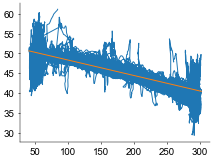

In [48]:
plt.plot(rcov[0], rcov[1])
xx = np.linspace(left_x, right_x, 100)
plt.plot(xx, a*xx+b)

In [56]:
data_run = (
    grid_size_pos, grid_shape_pos, field_pos, ff_pos, 
    grid_size_xt, grid_shape_xt, field_xt, ff_xt, 
    grid_size_xth, grid_shape_xth, field_xth, ff_xth, 
    lower_theta, mean_theta, upper_theta, fflower_theta, ffmean_theta, ffupper_theta, covariates_theta, 
    lower_hd, mean_hd, upper_hd, fflower_hd, ffmean_hd, ffupper_hd, covariates_hd, 
    lower_s, mean_s, upper_s, fflower_s, ffmean_s, ffupper_s, covariates_s, 
    show_neuron, max_count, tbin, rcov
)

pickle.dump(data_run, open('./checkpoint/P_CA1D_rg.p', 'wb'))